In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn import preprocessing


In [2]:
df = pd.read_csv('yahoo_Stocks_pivot.csv', index_col=0)  

df = df.dropna(how='any',axis=0) 
df = df.drop(columns=['Adj Close'])
df

,Name,Close,High,Low,Open,Volume
Date,,,,,,
1/2/2020,MSFT,160.619995,160.729996,158.330002,158.779999,22622100.0
1/3/2020,MSFT,158.619995,159.949997,158.059998,158.320007,21116200.0
1/6/2020,MSFT,159.029999,159.100006,156.509995,157.080002,20813700.0
1/7/2020,MSFT,157.580002,159.669998,157.320007,159.320007,21634100.0
1/8/2020,MSFT,160.089996,160.800003,157.949997,158.929993,27746500.0
...,...,...,...,...,...,...
7/27/2020,INTC,49.570000,51.139999,49.470001,51.029999,107526500.0
7/28/2020,INTC,49.240002,50.230000,49.139999,49.480000,62362600.0
7/29/2020,INTC,48.070000,49.500000,47.900002,49.490002,60500800.0


In [19]:
MSFT = df.loc[df['Name'] == 'MSFT']
MSFT = MSFT.drop(columns=['Name'])
print (MSFT)

                Close        High         Low        Open      Volume
Date                                                                 
1/2/2020   160.619995  160.729996  158.330002  158.779999  22622100.0
1/3/2020   158.619995  159.949997  158.059998  158.320007  21116200.0
1/6/2020   159.029999  159.100006  156.509995  157.080002  20813700.0
1/7/2020   157.580002  159.669998  157.320007  159.320007  21634100.0
1/8/2020   160.089996  160.800003  157.949997  158.929993  27746500.0
...               ...         ...         ...         ...         ...
7/27/2020  203.850006  203.970001  200.860001  201.470001  30160900.0
7/28/2020  202.020004  204.699997  201.740005  203.610001  23251400.0
7/29/2020  204.059998  204.649994  202.009995  202.500000  19632600.0
7/30/2020  203.899994  204.460007  199.570007  201.000000  25079600.0
7/31/2020  205.009995  205.100006  199.009995  204.399994  51248000.0

[147 rows x 5 columns]


In [20]:

MSFT

,Close,High,Low,Open,Volume
Date,,,,,
1/2/2020,160.619995,160.729996,158.330002,158.779999,22622100.0
1/3/2020,158.619995,159.949997,158.059998,158.320007,21116200.0
1/6/2020,159.029999,159.100006,156.509995,157.080002,20813700.0
1/7/2020,157.580002,159.669998,157.320007,159.320007,21634100.0
1/8/2020,160.089996,160.800003,157.949997,158.929993,27746500.0
...,...,...,...,...,...
7/27/2020,203.850006,203.970001,200.860001,201.470001,30160900.0
7/28/2020,202.020004,204.699997,201.740005,203.610001,23251400.0
7/29/2020,204.059998,204.649994,202.009995,202.500000,19632600.0


In [21]:
MSFT.dtypes

Close     float64
High      float64
Low       float64
Open      float64
Volume    float64
dtype: object

# New Section

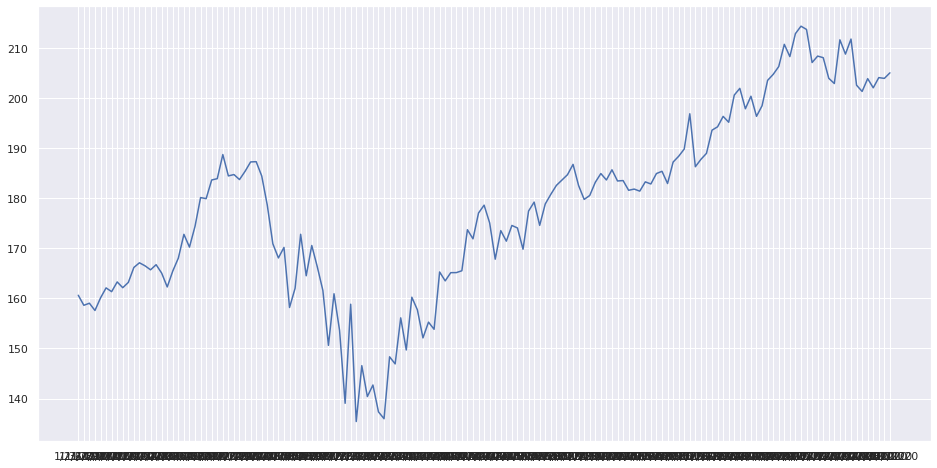

In [22]:
#plot
plt.figure(figsize=(16,8))
plt.plot(MSFT['Close'], label='Close Price history')

In [23]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [24]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
# tf.compat.v1.random.set_random_seed(1234)
# print(tf.__version__)

In [25]:

minmax = MinMaxScaler().fit(MSFT.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(MSFT.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.038604
1,0.019158
2,0.015252
3,0.025845
4,0.104775



Split train and test
I will cut the dataset to train and test datasets,

Train dataset derived from starting timestamp until last 30 days
Test dataset derived from last 30 days until end of the dataset
So we will let the model do forecasting based on last 30 days, and we will going to repeat the experiment for 10 times. You can increase it locally if you want, and tuning parameters will help you by a lot.

In [26]:
test_size = 120
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
MSFT.shape, df_train.shape, df_test.shape

((147, 5), (27, 1), (120, 1))

In [27]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            # return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
            return tf.contrib.rnn.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.contrib.rnn.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [28]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [29]:
# from tensorflow.python.framework import ops
# ops.reset_default_graph()
# # from tensorflow.keras.models import Sequential
# # tf.compat.v1.disable_eager_execution()
# print(tf.compat.v1.get_default_graph())

In [30]:
!pip install tensorflow==1.1

In [31]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(MSFT.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [32]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


train loop: 100%|██████████| 300/300 [00:08<00:00, 36.18it/s, acc=96.6, cost=0.00184]


simulation 2


train loop: 100%|██████████| 300/300 [00:08<00:00, 35.94it/s, acc=94.8, cost=0.00416]


simulation 3


train loop: 100%|██████████| 300/300 [00:08<00:00, 33.80it/s, acc=95.5, cost=0.00413]


simulation 4


train loop: 100%|██████████| 300/300 [00:08<00:00, 35.71it/s, acc=95.3, cost=0.00407]


simulation 5


train loop: 100%|██████████| 300/300 [00:08<00:00, 36.44it/s, acc=96.5, cost=0.00194]


simulation 6


train loop: 100%|██████████| 300/300 [00:08<00:00, 37.14it/s, acc=97.2, cost=0.00147]


simulation 7


train loop: 100%|██████████| 300/300 [00:08<00:00, 34.04it/s, acc=96.5, cost=0.00185]


simulation 8


train loop: 100%|██████████| 300/300 [00:09<00:00, 30.31it/s, acc=97.3, cost=0.0012]


simulation 9


train loop: 100%|██████████| 300/300 [00:09<00:00, 32.40it/s, acc=95.3, cost=0.00368]


simulation 10


train loop: 100%|██████████| 300/300 [00:08<00:00, 33.47it/s, acc=96.1, cost=0.00274]


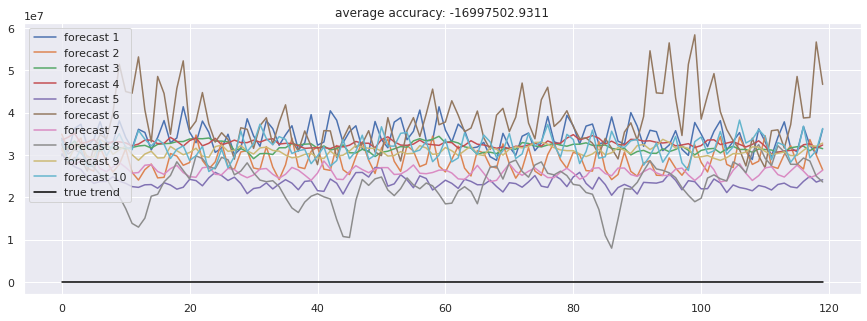

In [33]:
accuracies = [calculate_accuracy(MSFT['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(MSFT['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()